# Tutorial #2
# VGG Fine-Tuning

This course is adapted from [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) 

## 介绍

这个教程讲述用Keras API完成迁移学习和微调(fine-tune)。 这次教程使用VGG16模型。

我们会用到Knifey-Spoony数据集(含有刀子、叉子、汤匙)。 Knifey-Spoony数据集由一个视频文件取出帧并转换成图像产生。 训练集包含4170幅图像，测试集包含530幅图像。 训练集中只有994张叉子的图像，却包含着1201张刀子的图像和1966张汤匙的图像。 The classes are named knifey, spoony and forky as a reference to The Simpsons. 

注意：运行这份Notebook在一个2.6 GHz CPU和GTX 1070 GPU的笔记本电脑上需要15分钟。如果只在CPU上运行，需要将近10小时！

## 流程图

主要思路是重利用一个预训练模型，在这次例子中用的是VGG16模型，它包括了一些卷积层块，然后连接一些全连接层（密集层）和一个用于分类任务的softmax输出层。

全连接层的作用是连接卷积层的特征和用于最后的分类。使用VGG16在新的数据集上时，我们需要替换掉所有的全连接层。在这个例子中我们增加另一个全连接层和一个避免过拟合的dropout(随机失活)层。

这个例子的迁移学习和微调的区别是: 这里的迁移学习只优化我们增加的新分类层的权重，同时保持原始VGG16模型的权重不变。在微调中，我们优化新增加的分类层以及VGG16模型中更多层的权重。

![Flowchart of Transfer Learning & Fine-Tuning](images/02_transfer_learning_flowchart.png)

## 导入

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

这里需要导入Keras API。

In [2]:
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam, RMSprop

开发环境Python 3.6和TensorFlow版本：

In [3]:
tf.__version__

'1.9.0'

## 辅助函数

### 用于加入目录和文件名的辅助函数

In [4]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

### 用于画图的辅助函数

用于画出3x3栅格的9幅图，并在下方显示正确的和预测的类别的函数。

In [5]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 画混淆矩阵的函数

In [6]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

### 画出错误分类的辅助函数

画出一些测试集中被错误分类图片的函数。

In [7]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

用于计算整个测试集预测的类别并且调用上面的函数画出一些被错误分类的图像的例子的函数。

In [8]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

### 加载图片的辅助函数

数据集没有被加载到内存中，作为替代的是它有一个训练集的图像文件列表和一个测试集的图像文件列表。这个辅助函数用于加载一些图像文件。

In [9]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

### 画出训练历史的辅助函数

用Keras API画出在训练时分类的准确率和损失值。

In [10]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

## 训练集: Knifey-Spoony

In [11]:
import knifey

Download and extract the dataset if it hasn't already been done. It is about 22 MB.

下载地址：https://github.com/Hvass-Labs/knifey-spoony/raw/master/knifey-spoony.tar.gz

下载后放置目录：data/knifey-spoony/

In [12]:
knifey.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


这个数据集的目录结构和Keras API要求的不一致，因此将这些文件复制到单独的训练和测试集目录中。

In [13]:
knifey.copy_files()

Creating dataset from the files in: data/knifey-spoony/
- Data loaded from cache-file: data/knifey-spoony/knifey-spoony.pkl
- Copied training-set to: data/knifey-spoony/train/
- Copied test-set to: data/knifey-spoony/test/


现在保存好了图像的目录。

In [14]:
train_dir = knifey.train_dir
test_dir = knifey.test_dir

## 预训练模型: VGG16

下面创建了一个通过使用Keras API预训练VGG16模型的实例。如果你之前没有使用，它将自动下载需要的文件。

VGG16模型包含卷积部分和用于分类的全连接部分。如果 `include_top=True`那么会下载完整的VGG16模型，大约 518 MB。如果 `include_top=False`，那么只下载包含卷积部分的模型，大约 57 MB。

我们将使用预训练模型在新的数据集上预测一些图片，所以需要下载整个模型，但是如果你的网速很慢，那么你可以修改这个代码，只下载卷积部分的模型。

In [15]:
model = VGG16(include_top=True, weights='imagenet')

## 输入流水线(Pipeline)

Keras API有它自己的方式创建用于训练模型文件的输入流水线。

首先，我们需要知道预训练的VGG16模型所需要输入张量的形状。在这个例子中图像的形状是224 x 224 x 3。

In [16]:
input_shape = model.layers[0].output_shape[1:3]
input_shape

(224, 224)

Keras 用一个称为数据生成器(data-generator)输入数据到神经网络中，它将在整个数据上循环。

我们只有一个小型的训练集，所以需要通过对图像进行各种变换来人为地增加它的数量。我们使用内置的数据生成器，可以进行这些随机转换。这也被称为数据增强(data augamentation)。

In [17]:
datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

我们也可需要一个测试集的数据生成器，但是它不应该对图像做变换，因为我们想知道这些特定图像的精确分类精度。所以我们只是重新调整像素值，它们在0.0到1.0之间，因为这是VGG16模型所期望的。

In [18]:
datagen_test = ImageDataGenerator(rescale=1./255)

数据生成器将返回一批图像。因为VGG16模型很大，批的大小不能设置的很大，否者你的GPU会内存溢出。

In [19]:
batch_size = 20

我们可以保存在训练过程中随机变换的图像，可以检查它们是否被过度扭曲了，如果被过度扭曲了，我们可以调整上面数据生成器中的参数。

In [20]:
if True:
    save_to_dir = None
else:
    save_to_dir='augmented_images/'

现在我们创建数据生成器的实例，它将从硬盘中读取文件，缩放图像并返回随机的批。

数据生成器的构建被划分为这两个步骤，有点笨拙，但这可能是因为不同的数据类型（图像、文本等）和源（内存或磁盘）有不同类型的数据生成器可用。

In [23]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)

Found 4170 images belonging to 5 classes.


测试集的数据生成器不应该有图像转换和顺序打乱。

In [24]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 530 images belonging to 5 classes.


因为数据生成器将在整个数据上循环，我们需要指定在测试集中的评估和预测中执行的步骤数量。因为测试集包含530张图像，批大小被设置成20，对于测试集的一个完整处理，步骤数量是26.5。这也是为什么需要在上面的 `example_errors()`函数中重置数据生成器的计数器，那么它将总是从测试集的开始处进行处理。

这是Keras API另一个有点笨拙的方面，它可能会得到改进。

In [25]:
steps_test = generator_test.n / batch_size
steps_test

26.5

获取训练集和测试集中的所有图像的文件路径。

In [26]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

获得训练集和测试集所有图像的类别。

In [27]:
cls_train = generator_train.classes
cls_test = generator_test.classes

获得数据集的类别名。

In [28]:
class_names = list(generator_train.class_indices.keys())
class_names

['forky', 'knifey', 'spoony', 'test', 'train']

获得数据集的类别数目。

In [29]:
num_classes = generator_train.num_classes
num_classes

5

### 画一些图像检测数据是否正确

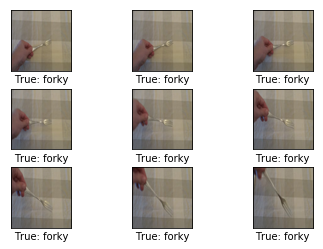

In [30]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

### 类别的权重

Knifey-Spoony数据集是相当不平衡的，因为叉子的图像很少，刀的图像比较多，汤匙的图片非常多。这可能会在训练过程中产生问题，因为神经网络将会看到汤匙的例子比叉子多，所欲它可能更倾向于识别汤匙。

这里我们是用scikit-learn去计算权重尽可能平衡数据集。在训练过程中，为了扩大它们对这批图像整体梯度的影响，这些权重被应用到每个图像的梯度计算上。

In [31]:
from sklearn.utils.class_weight import compute_class_weight

In [32]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

注意到叉子类别的权重大约1.398，汤匙类的权重只有0.707.这是因为叉子类别的图像少，所以这些图像的梯度应该被放大，同时汤匙的梯度应该被减小。

In [33]:
class_weight

array([1.39839034, 1.14876033, 0.70701933])

In [34]:
class_names

['forky', 'knifey', 'spoony', 'test', 'train']

## 预测举例

这里我们展示一些用预训练VGG16预测的例子。

我们需要一个辅助函数用于加载并缩放图像，它可以被输入到VGG16模型中，并且做出预测和显示其结果。

In [35]:
def predict(image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Use the VGG16 model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = model.predict(img_array)
    
    # Decode the output of the VGG16 model.
    pred_decoded = decode_predictions(pred)[0]

    # Print the predictions.
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

然后可以在一只鹦鹉的照片上使用VGG16模型，它被归类为金刚鹦鹉（鹦鹉），得分相当高79%。

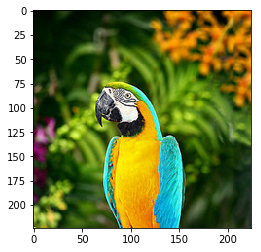

79.02% : macaw
 6.61% : bubble
 3.64% : vine_snake
 1.90% : pinwheel
 1.22% : knot


In [36]:
predict(image_path='images/parrot_cropped1.jpg')

我们用VGG16模型去预测新的训练集中的图像。VGG16模型对这张图片非常困惑，不能做出正确的分类。

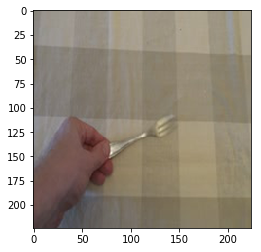

50.31% : shower_curtain
17.08% : handkerchief
12.75% : mosquito_net
 2.87% : window_shade
 1.32% : toilet_tissue


In [37]:
predict(image_path=image_paths_train[0])

我们尝试用训练集中另一张图像，VGG16仍然表现的很困惑。

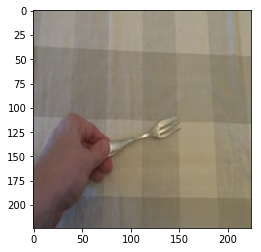

45.08% : shower_curtain
21.84% : mosquito_net
11.55% : handkerchief
 2.02% : window_shade
 0.91% : Windsor_tie


In [38]:
predict(image_path=image_paths_train[1])

我们尝试用测试集中一张图像，VGG16再次表现的很困惑。

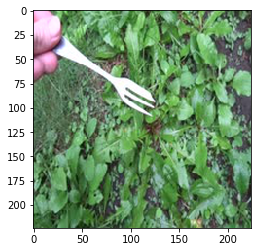

26.75% : spoonbill
 7.06% : black_stork
 7.04% : wooden_spoon
 4.21% : limpkin
 3.72% : paddle


In [39]:
predict(image_path=image_paths_test[0])

## 迁移学习

预训练VGG16模型不可能对Knifey-Spoony数据集图像做出分类。因为训练VGG16模型的数据集是ImageNet，其中可能没有很多关于餐具的图片。

低层的卷积神经网络可以识别图像中的不同形状。它是最后几个全连接的层将这些特征组合成整个图像的分类。因此，我们可以尝试将VGG16模型的最后一个卷积层的输出重新接到一个新的全连接神经网络，用它来对Knifey-Spoony数据集进行分类。

首先我们打印出VGG16模型的结构，我们可以看到这些层的名字和类型，也可以看到层与层之间传输的张量的形状。 

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

可以看到最后一个卷积层'block5_pool'，我们用Keras获取这个层的引用。

In [41]:
transfer_layer = model.get_layer('block5_pool')

我们将这一层称为迁移层，因为它的输出将被重新接到我们新的全连接神经网络，对Knifey-Spoony数据集进行分类。

迁移层的输出的张量形状如下：

In [42]:
transfer_layer.output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

使用Kears API创建一个新的模型很容易。首先从VGG16模型中获取它输入层到迁移层输出的部分。我们称它为卷积模型，因为它包含了VGG16模型中所有的卷积层。

In [43]:
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

然后我们可以使用Keras在上面构建一个新的模型。

In [44]:
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
new_model.add(Dense(num_classes, activation='softmax'))

我们使用学习率非常低的Adam优化器。学习率可能可以再大一些。但是如果你尝试去训练更多的原始VGG16模型，那么学习率应该被设置的低一些，否者预训练模型的权重将会被扭曲，它将无法学习。

In [45]:
optimizer = Adam(lr=1e-5)

在Knifey-Spoony数据集中有3个类，所以Keras需要去使用这个分类损失函数。

In [46]:
loss = 'categorical_crossentropy'

我们感兴趣的唯一性能指标是分类准确率。

In [47]:
metrics = ['categorical_accuracy']

用于打印VGG16模型的每一层是否可以被训练的辅助函数。

In [48]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

VGG16模型的每一层默认都是可以被训练的。

In [49]:
print_layer_trainable()

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


在迁移学习中，我们最初只对重用预训练VGG16模型感兴趣，因此禁用所有层的训练。

In [50]:
conv_model.trainable = False

In [51]:
for layer in conv_model.layers:
    layer.trainable = False

In [52]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


一旦我们改变了模型的层是否可训练，我们就需要编译模型来进行更改。

In [53]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

一个epoch通常意味处理整个训练集。但是我们之前创建的数据生成器，将会处理不断的从训练数据中产生批。所以我们需要定义我们想要为每个“epoch”运行的步骤的数量，这个数字会乘以上面定义的批处理大小。这次，每个epoch有100步，一个批大小为20，所以一个 "epoch"包含2000个从训练集中产生的随机的图像。我们运行20个这样的"epochs"。

选择这些数字的原因是它们似乎已经足够用于这个模型和数据集的训练了，并且它花费的时间较少，并产生了20个数据点（每一个“epochs”），可以在之后绘制。

In [54]:
epochs = 20
steps_per_epoch = 100

训练这个新的模型只需要调用Keras API中的一个函数。 

In [55]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/20
100/100 [==============================] - 541s 5s/step - loss: 1.2959 - categorical_accuracy: 0.4035 - val_loss: 0.8187 - val_categorical_accuracy: 0.5887
Epoch 2/20
100/100 [==============================] - 541s 5s/step - loss: 0.9948 - categorical_accuracy: 0.5270 - val_loss: 0.6801 - val_categorical_accuracy: 0.8302
Epoch 3/20
100/100 [==============================] - 541s 5s/step - loss: 0.8752 - categorical_accuracy: 0.6070 - val_loss: 0.7031 - val_categorical_accuracy: 0.6830
Epoch 4/20
100/100 [==============================] - 549s 5s/step - loss: 0.8360 - categorical_accuracy: 0.6170 - val_loss: 0.6254 - val_categorical_accuracy: 0.8151
Epoch 5/20
100/100 [==============================] - 549s 5s/step - loss: 0.7416 - categorical_accuracy: 0.6680 - val_loss: 0.5587 - val_categorical_accuracy: 0.8396
Epoch 6/20
100/100 [==============================] - 547s 5s/step - loss: 0.7380 - categorical_accuracy: 0.6790 - val_loss: 0.5696 - val_categorical_accuracy: 0.792

Keras在每个“epoch”结束时记录性能指标，以便稍后进行绘图。下图表明，在训练期间，训练集的损失值通常会降低，但测试集的损失值有点不稳定。相同的是，在训练集上，分类精度通常有所提高，而在测试集中有些不稳定。

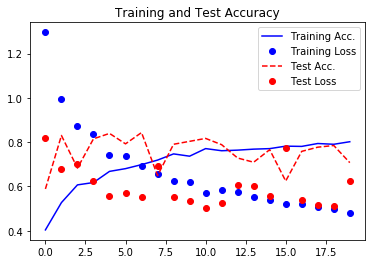

In [56]:
plot_training_history(history)

在训练之后，我们还可以使用Keras API中的单个函数来评估新模型在测试集中的性能。

In [57]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [58]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 70.75%


我们可以从测试集中绘制一些错误分类图像的例子。其中一些图像对于人类来说也很难归类。

混淆矩阵表明，新模型在对叉子类进行分类时存在问题比较明显。

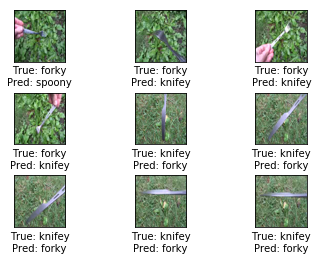

Confusion matrix:
[[147   3   1]
 [ 60  77   0]
 [ 87   4 151]]
(0) forky
(1) knifey
(2) spoony
(3) test
(4) train


In [59]:
example_errors()

## 微调

对于迁移学习，原始的预训练模型在训练新的分类过程中被冻结了。这确保原始VGG16模型的权重不被改变。这样的好处是，新分类器的训练不会通过VGG16模型传播大的梯度，导致扭曲它原来的权重，或者导致模型对新数据集过度拟合。

但是一旦新的分类层被训练好了，我们可以尝试微调VGG16模型一些较深的层。称之为微调。

目前还不清楚Keras是否在原始VGG16模型的每一层中使用了`trainable`的布尔值，或者是否它用`trainable` 布尔值覆盖`conv_layer`。因此，我们将在原始的VGG16模型中对所有相关的层启用 `trainable` 的布尔值。

In [60]:
conv_model.trainable = True

我们想要训练最后两个卷积层：'block5' 和 'block4'。

In [61]:
for layer in conv_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

我们可以检查它是否更新了相关层的`trainable`布尔值。

In [62]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


我们将使用很小的学习率去微调，因为我们希望原始VGG16模型的权重被慢慢的改变。

In [63]:
optimizer_fine = Adam(lr=1e-7)

因为我们定义了新的优化器并改变了一些层的`trainable`布尔值，需要编译一下这个模型，使这些改变能在接下去的训练中生效。

In [64]:
new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

然后可以继续进行训练，对VGG16模型和新的分类器进行微调。

In [65]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/20
100/100 [==============================] - 814s 8s/step - loss: 0.4626 - categorical_accuracy: 0.8095 - val_loss: 0.5332 - val_categorical_accuracy: 0.7717
Epoch 2/20
100/100 [==============================] - 823s 8s/step - loss: 0.4662 - categorical_accuracy: 0.8150 - val_loss: 0.5236 - val_categorical_accuracy: 0.7755
Epoch 3/20
100/100 [==============================] - 824s 8s/step - loss: 0.4506 - categorical_accuracy: 0.8140 - val_loss: 0.5153 - val_categorical_accuracy: 0.7830
Epoch 4/20
100/100 [==============================] - 821s 8s/step - loss: 0.4491 - categorical_accuracy: 0.8170 - val_loss: 0.5236 - val_categorical_accuracy: 0.7717
Epoch 5/20
100/100 [==============================] - 820s 8s/step - loss: 0.4612 - categorical_accuracy: 0.8150 - val_loss: 0.5244 - val_categorical_accuracy: 0.7698
Epoch 6/20
100/100 [==============================] - 824s 8s/step - loss: 0.4440 - categorical_accuracy: 0.8215 - val_loss: 0.5078 - val_categorical_accuracy: 0.784

我们可以画出训练时的损失值和分类精度。根据数据集，原始的模型，新的分类器，学习率等超参数，这些操作可能同时提高训练集和测试集上分类的准确率，或者它可以能提高训练集上分类的准确率，但是由于过拟合导致在测试集上表现的很差。这可能需要一些调参的经验。

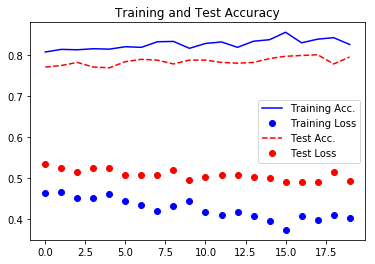

In [66]:
plot_training_history(history)

In [67]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [68]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 79.62%


我们可以再次画出一些被错误分类的图片，还可以从混淆矩阵中看出模型仍然对叉子的分类存在问题。

一部分原因可能是训练集中只有994张叉子的图像，却包含着1201张刀子的图像和1966张汤匙的图像。尽管我们已经对这些类进行了加权以补偿这种不平衡，我们还通过在训练中以不同的方式随机变换图像来增强训练集，但是这对于模型来说仍然不足以让模型学习识别叉子。

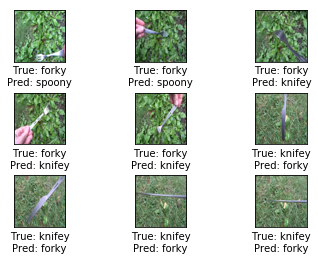

Confusion matrix:
[[146   3   2]
 [ 50  87   0]
 [ 51   2 189]]
(0) forky
(1) knifey
(2) spoony
(3) test
(4) train


In [69]:
example_errors()

## 总结

这份教程展示了如何利用Keras API去利用预训练模型在新的数据集上完成迁移学习和微调。

微调是否能提高分类的准确率取决于迁移学习选择的预训练模型、选择的迁移层、你的数据集和训练方式。你可能会从微调中获得更好的性能，也可能由于微调模型导致模型对数据集过拟合使性能更差。


## 练习

下面使一些可能会让你提升TensorFlow技能的一些建议练习。为了学习如何更合适地使用TensorFlow，实践经验是很重要的。

在你对这个Notebook进行修改之前，可能需要先备份一下。

* 尝试使用VGG16模型的其它层来作为传输层。它如何影响训练和分类的准确性？
* 改变我们添加的新的分类层。你能通过增加或减少全连接层的节点数量来提高分类精度吗？
* 如果你在新的分类器中移除随机失活层会发生什么？
* 改变迁移学习和微调时的学习率。
* 尝试微调整个VGG16模型。它如何影响训练和测试集的分类精度？为什么?
* 试着从一开始就进行微调，这样新的分类层就会和VGG16模型的所有卷积层一起开始训练。您可能需要降低优化器的学习速度。
* 给测试集和训练集添加一些图像。这样能使性能提升吗？
* 尝试删除一些刀和汤匙的图像，使所有类别的图像数目相等。这是否改善了混淆矩阵中的数字？
* Use another dataset.
* 使用另一个数据集。
* 使用Keras中另一个预训练模型。
* 向朋友解释程序如何工作。

## License (MIT)

Copyright (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.